<a href="https://colab.research.google.com/github/sathyamsn/samples/blob/master/custom_classifier_mnet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
## !mv classification.zip './drive/My Drive/Data Set/'
# !unzip './drive/My Drive/Data Set/classification.zip' -d './drive/My Drive/Data Set/'

In [0]:
! ls './drive/My Drive/Data Set/classification/trn' | wc -l

3


In [0]:
!pip install torchnet

In [0]:
from torchvision import models
import torch

dir(models)

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'utils',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vg

In [0]:
# Standard library
import copy
import glob
import multiprocessing
import os
import time
import zipfile

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

# Related third party
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from skimage import io, transform
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import torchnet.meter.confusionmeter as cm

In [0]:
input_size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Number of classes in the dataset
num_classes = 3 # 

# Batch size for training (change depending on how much memory you have)
batch_size = 16

# Number of epochs to train for
num_epochs = 2

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Switch to perform multi-process data loading
num_workers = multiprocessing.cpu_count()

Create training and validation datasets


In [0]:
import torch
from torchvision import transforms, datasets

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './drive/My Drive/Data Set/classification'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                              shuffle=True, num_workers=num_workers)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [0]:
print('class_names : ', class_names)
print('dataset_sizes : ', dataset_sizes)

class_names :  ['charger', 'shoes', 'wires']
dataset_sizes :  {'train': 56243, 'val': 2078}


Visualize a few images

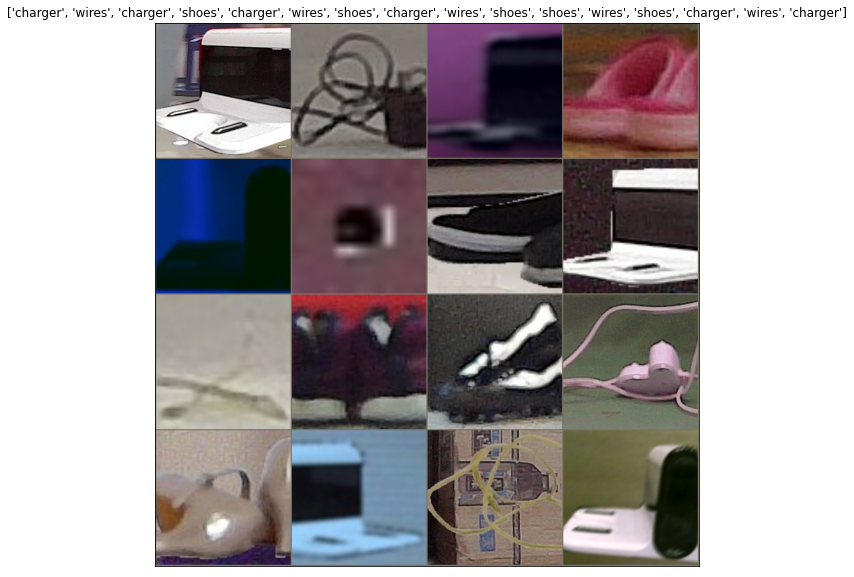

In [0]:
import torchvision

def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders_dict['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
imshow(out, title=[class_names[x] for x in classes], ax=ax)

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    history = {'accuracy': [],
               'val_accuracy': [],
               'loss': [],
               'val_loss': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
                history['accuracy'].append(epoch_acc.item())
                history['loss'].append(epoch_loss)
            else:
                history['val_accuracy'].append(epoch_acc.item())
                history['val_loss'].append(epoch_loss) 

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [0]:
train_list = image_datasets['train']
val_list = image_datasets['val']

In [0]:

print(len(train_list))
print(len(val_list))

56243
2078


In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size, scale=(0.5, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

In [0]:
model_ft = models.mobilenet_v2(pretrained=True)
#model_ft.classifier[1] = nn.Linear(4096, num_classes)
print(model_ft.classifier)



Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [0]:
model_ft.classifier[1] = torch.nn.Linear(in_features=model_ft.classifier[1].in_features, out_features=num_classes)
print(model_ft.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)


In [0]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.0.weight
	 features.0.1.weight
	 features.0.1.bias
	 features.1.conv.0.0.weight
	 features.1.conv.0.1.weight
	 features.1.conv.0.1.bias
	 features.1.conv.1.weight
	 features.1.conv.2.weight
	 features.1.conv.2.bias
	 features.2.conv.0.0.weight
	 features.2.conv.0.1.weight
	 features.2.conv.0.1.bias
	 features.2.conv.1.0.weight
	 features.2.conv.1.1.weight
	 features.2.conv.1.1.bias
	 features.2.conv.2.weight
	 features.2.conv.3.weight
	 features.2.conv.3.bias
	 features.3.conv.0.0.weight
	 features.3.conv.0.1.weight
	 features.3.conv.0.1.bias
	 features.3.conv.1.0.weight
	 features.3.conv.1.1.weight
	 features.3.conv.1.1.bias
	 features.3.conv.2.weight
	 features.3.conv.3.weight
	 features.3.conv.3.bias
	 features.4.conv.0.0.weight
	 features.4.conv.0.1.weight
	 features.4.conv.0.1.bias
	 features.4.conv.1.0.weight
	 features.4.conv.1.1.weight
	 features.4.conv.1.1.bias
	 features.4.conv.2.weight
	 features.4.conv.3.weight
	 features.4.conv.3.bias
	 featur

In [0]:
!nvidia-smi


Tue Jun 16 07:19:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    24W /  75W |    555MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [0]:

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)



Epoch 0/1
----------


In [0]:
#Change path with yours
!mkdir models
torch.save(model_ft.state_dict(), './models/custm_model_ft_mnv2.pth')
torch.save(model_ft.state_dict(), './drive/My Drive/Data Set/models/custm_model_ft_mnv2.pth')


mkdir: cannot create directory ‘models’: File exists


## https://github.com/haritha91/Multiclass-Image-Classifier-pytorch-Transfer-Learning/blob/master/multiclass_classifier.py

Visualize training results

In [0]:
acc = hist['accuracy']
val_acc = hist['val_accuracy']
loss = hist['loss']
val_loss = hist['val_loss']
epochs_range = range(num_epochs)

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: ignored

In [0]:

#Change path with yours
path = './drive/My Drive/Data Set/models/custm_model_ft_mnv2.pth'

model = model_ft  

model.load_state_dict(torch.load(path))

<All keys matched successfully>

Predict

In [0]:
# train data file looks './train/dog.10435.jpg'
# test data file looks './test/10435.jpg'
# def extract_class_from(path):
#     file = path.split('/')[-1]
#     return file.split('.')[0]

# test_dir = './drive/My Drive/Data Set/classification/val/shoes/'
# test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
# test_data_transform = data_transforms['val']

# ids = []
# labels = []
# print (test_list)
# with torch.no_grad():
#     for test_path in tqdm(test_list):
#         img = Image.open(test_path)
#         img = test_data_transform(img)
#         img = img.unsqueeze(0)
#         img = img.to(device)

#         model_ft.eval()
#         outputs = model_ft(img)
#         preds = F.softmax(outputs, dim=1)[:, 1].tolist()
#         print(preds)
#         test_id = extract_class_from(test_path)
#         ids.append((test_id))
#         labels.append(preds[0])

In [0]:
#Test the accuracy with test data
correct = 0
total = 0
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders_dict['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 52 %


In [0]:
#Class wise testing accuracy
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders_dict['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs, 1)
            point = (predicted == labels).squeeze()
            # print(labels)
            for j in range(len(labels)):
                label = labels[j]
                class_correct[label] += point[j].item()
                class_total[label] += 1

for i in range(num_classes):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))



Accuracy of charger : 91 %
Accuracy of shoes : 45 %
Accuracy of wires : 95 %


In [0]:
!pip install torchnet

In [0]:
#Get the confusion matrix for testing data
import torchnet.meter.confusionmeter as cm
confusion_matrix = cm.ConfusionMeter(num_classes)
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders_dict['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs, 1)
        confusion_matrix.add(predicted, labels)
    print(confusion_matrix.conf)


[[  49   19    4]
 [   0 1764    8]
 [   0    0  234]]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


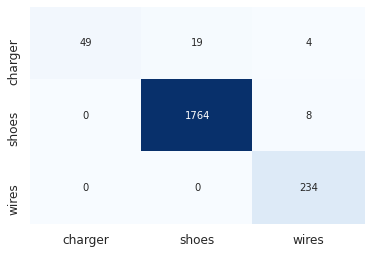

In [0]:
#Confusion matrix as a heatmap
import seaborn as sn
con_m = confusion_matrix.conf
df_con_m = pd.DataFrame(con_m, index= [i for i in class_names], columns = [i for i in class_names])
sn.set(font_scale= 1.1)
sn.heatmap(df_con_m, annot=True,fmt='g' ,  annot_kws={"size" : 10}, cbar = False, cmap="Blues") 

In [0]:
# train data file looks './train/dog.10435.jpg'
# test data file looks './test/10435.jpg'
def extract_class_from(path):
    file = path.split('/')[-1]
    return file.split('.')[0]

test_dir = './drive/My Drive/Data Set/classification/val/shoes/'
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
test_data_transform = data_transforms['val']

images = []
labels = []
probs = []

with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders_dict['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs, 1)
            point = (predicted == labels).squeeze()
            for j in range(len(labels)):
                label = labels[j]
                class_correct[label] += point[j].item()
                class_total[label] += 1


ValueError: ignored

**Check Prediction** 

[0.7721839547157288, 0.5553886294364929, 0.772405207157135, 0.7380952835083008, 0.7169186472892761, 0.7172445058822632, 0.7958582043647766, 0.7448967099189758, 0.7251673936843872, 0.7425090670585632, 0.710060715675354, 0.7558629512786865, 0.7414856553077698, 0.6690888404846191, 0.7622572779655457, 0.6937057971954346, 0.7402044534683228, 0.7183876037597656, 0.7531518340110779, 0.712186336517334, 0.7691376209259033, 0.7196131348609924, 0.7332318425178528, 0.7121857404708862, 0.7393333315849304, 0.754237174987793, 0.705272912979126, 0.7157933115959167, 0.6994627118110657, 0.7269783020019531, 0.7079237103462219, 0.7078419923782349, 0.7082090377807617, 0.6880960464477539, 0.7642880082130432, 0.7103416919708252, 0.7783640623092651, 0.7041128873825073, 0.6920327544212341, 0.7266963720321655, 0.6841541528701782, 0.7364107370376587, 0.7687699794769287, 0.7464170455932617, 0.6650643348693848, 0.777446985244751, 0.6657421588897705, 0.7063189148902893, 0.7307352423667908, 0.7254219651222229, 0.758

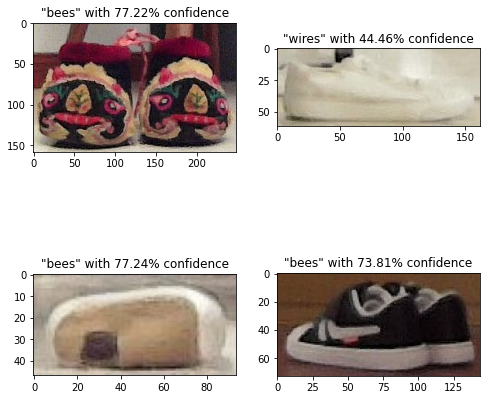

In [0]:
template = '"{}" with {:.2%} confidence'
print(labels)
def pred_result_message(pred):
    if pred > 0.7:
        return template.format('bees', pred)
    else:
        return template.format('wires', 1 - pred)

fig, axes = plt.subplots(nrows=2,
                         ncols=2,
                         figsize=(8, 8))
for img_path, label, ax in zip(test_list, labels, axes.ravel()):
    ax.set_title(pred_result_message(label))
    ax.imshow(Image.open(img_path))

## also check https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/finetuning_torchvision_models_tutorial.ipynb?authuser=1